In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import seaborn as sns
import shap

# Load the dataset
df = pd.read_csv('loan_data_1.csv')
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001003,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
1,1,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
2,2,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
3,3,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y
4,4,LP001013,Male,Yes,0,Not Graduate,No,2333.0,1516.0,95.0,360.0,1.0,Urban,Y


In [4]:
df.describe()

,Unnamed: 0,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,369.000000,363.000000,373.000000,370.000000,351.000000
mean,190.000000,3563.422764,1267.005289,104.914209,340.864865,0.837607
std,110.129469,1427.371257,2388.048316,28.484822,68.549257,0.369338
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,95.000000,2583.000000,0.000000,90.000000,360.000000,1.000000
50%,190.000000,3326.000000,830.000000,110.000000,360.000000,1.000000
75%,285.000000,4226.000000,2008.000000,127.000000,360.000000,1.000000
max,380.000000,9703.000000,33837.000000,150.000000,480.000000,1.000000


In [5]:
df.dtypes

Unnamed: 0             int64
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'Loan_ID'])

# Handle missing values
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Dependents'] = df['Dependents'].replace('3+', 3)  # Replace '3+' with numeric 3
df['Dependents'] = df['Dependents'].fillna(0).astype(int)
df['Education'] = df['Education'].fillna(df['Education'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna('No')  # Replace with most common value
df['ApplicantIncome'] = df['ApplicantIncome'].fillna(df['ApplicantIncome'].mean())
df['CoapplicantIncome'] = df['CoapplicantIncome'].fillna(df['CoapplicantIncome'].mean())
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

In [7]:
# Add a new feature: Total Income
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Apply log transformation to reduce skewness
df['LoanAmount'] = np.log1p(df['LoanAmount'])
df['Total_Income'] = np.log1p(df['Total_Income'])

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,Male,Yes,1,Graduate,No,4583.0,1508.0,4.859812,360.0,1.0,Rural,N,8.714732
1,Male,Yes,0,Graduate,Yes,3000.0,0.0,4.204693,360.0,1.0,Urban,Y,8.006701
2,Male,Yes,0,Not Graduate,No,2583.0,2358.0,4.795791,360.0,1.0,Urban,Y,8.505525
3,Male,No,0,Graduate,No,6000.0,0.0,4.955827,360.0,1.0,Urban,Y,8.699681
4,Male,Yes,0,Not Graduate,No,2333.0,1516.0,4.564348,360.0,1.0,Urban,Y,8.255828


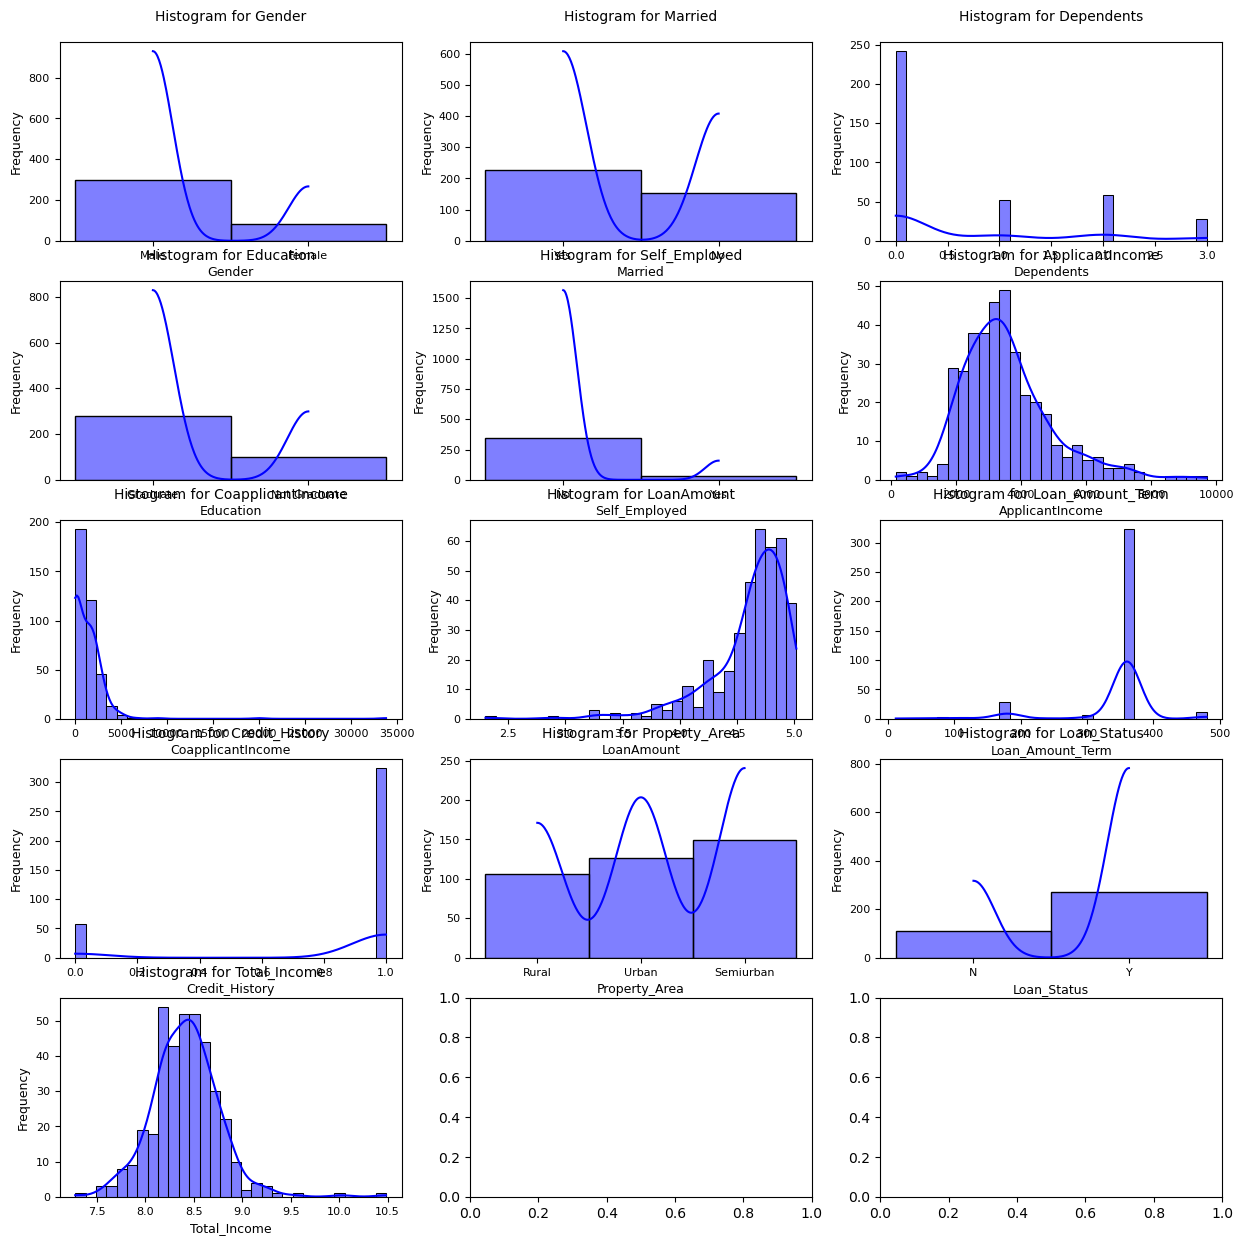

In [8]:
# Plot histograms for each feature 
num_columns = len(df.columns)
num_rows = (num_columns // 3) + (num_columns % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, bins=30, color='blue', ax=axes[i])
    axes[i].set_title(f'Histogram for {column}', fontsize=10, pad=15)
    axes[i].set_xlabel(column, fontsize=9)
    axes[i].set_ylabel('Frequency', fontsize=9)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

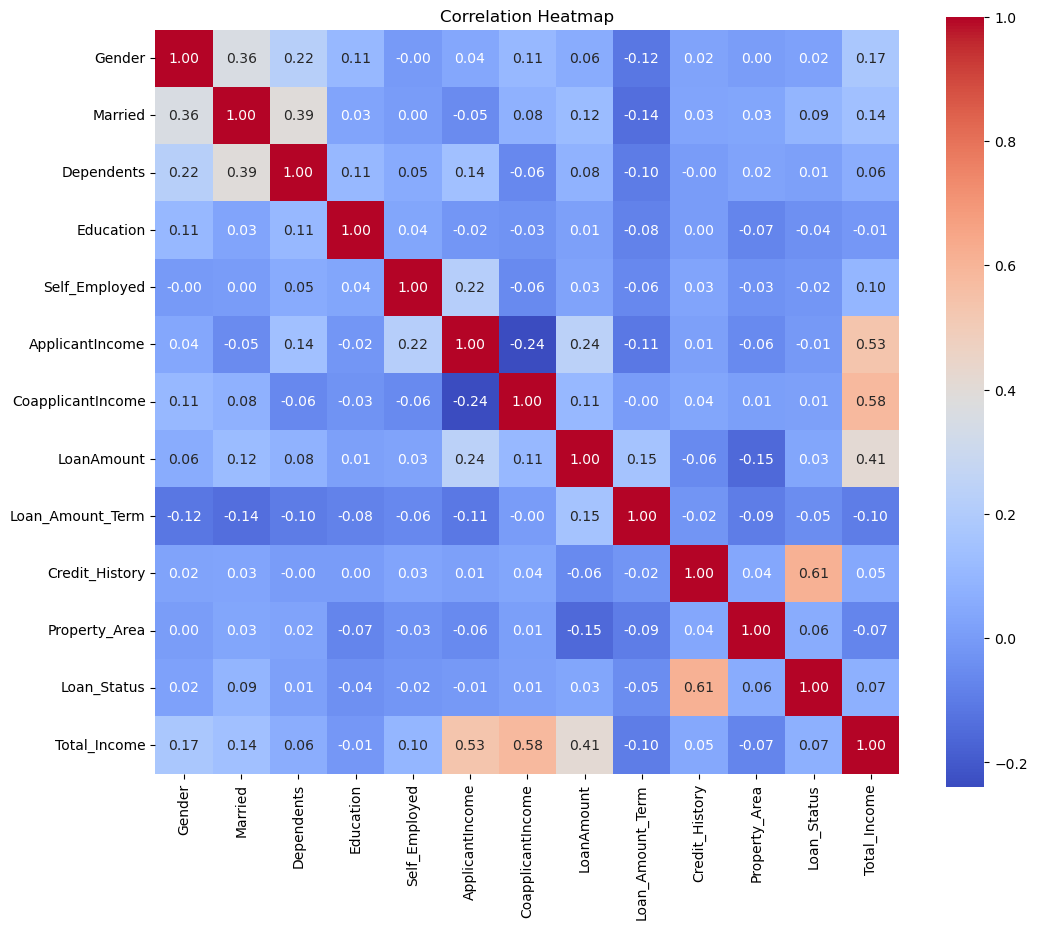

In [74]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap")
plt.show()

# Define features and target variable
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled dataset
xtrain, xtest, ytrain, ytest = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled)

# Scale features
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Model Evaluation Function
def evaluate_model(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    acc = accuracy_score(ytest, y_pred) * 100
    rec = recall_score(ytest, y_pred) * 100
    prec = precision_score(ytest, y_pred) * 100
    f1 = f1_score(ytest, y_pred) * 100

    # Confusion Matrix Visualization
    cm = confusion_matrix(ytest, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {acc:.2f}%")
    print(f"Recall: {rec:.2f}%")
    print(f"Precision: {prec:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    return acc, rec, prec, f1

def explain_model_with_shap(model, xtrain, xtest, feature_names):
    """
    General SHAP explanation logic for all callable models.
    """
    if isinstance(model, StackingClassifier):
        print("\nExplaining StackingClassifier...")
        
        # Explain base models
        for name, base_model in model.estimators:
            print(f"\nExplaining base model: {name}")
            explain_model_with_shap(base_model, xtrain, xtest, feature_names)
        
        # Explain meta-model (final_estimator)
        print("\nExplaining final estimator (meta-model)...")
        meta_features_train = model.transform(xtrain)
        meta_features_test = model.transform(xtest)
        final_estimator = model.final_estimator_
        
        explainer = shap.Explainer(final_estimator, meta_features_train)
        shap_values = explainer(meta_features_test)
        shap.summary_plot(shap_values, meta_features_test)
        shap.plots.waterfall(shap_values[0])
    else:
        # For single models (not StackingClassifier)
        print(f"\nExplaining model: {model.__class__.__name__}")
        explainer = shap.Explainer(model, xtrain)
        shap_values = explainer(xtest)
        shap.summary_plot(shap_values, xtest, feature_names=feature_names)
        
        # Waterfall plot for single predictions
        if hasattr(shap_values, "base_values") and len(shap_values.base_values) == 1:
            shap.plots.waterfall(shap_values[0])
        elif isinstance(shap_values, list) and len(shap_values) > 1:
            shap.plots.waterfall(shap_values[0][0])  # Multi-output models


--- Elbow Method for KNN ---


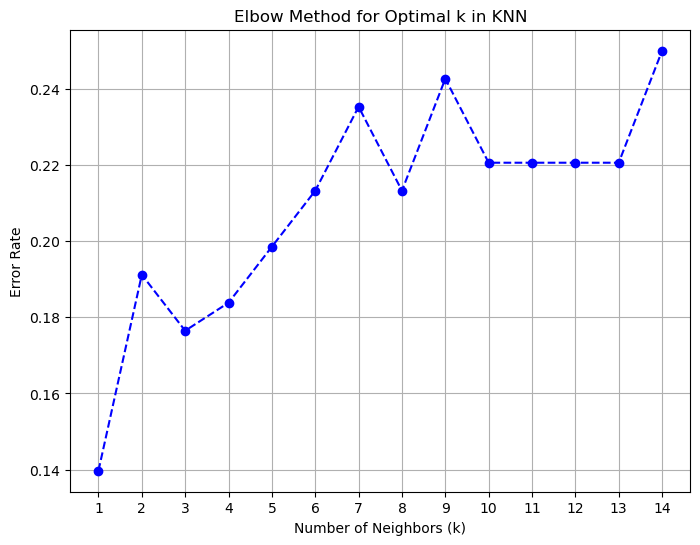

In [94]:
# Elbow Method for KNN
print("\n--- Elbow Method for KNN ---")
k_values = range(1, 15)
error_rates = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(xtrain, ytrain)
    y_pred = knn_temp.predict(xtest)
    error = 1 - accuracy_score(ytest, y_pred)
    error_rates.append(error)

plt.figure(figsize=(8, 6))
plt.plot(k_values, error_rates, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Elbow Method for Optimal k in KNN')
plt.xticks(k_values)
plt.grid()
plt.show()



--- KNN Model ---


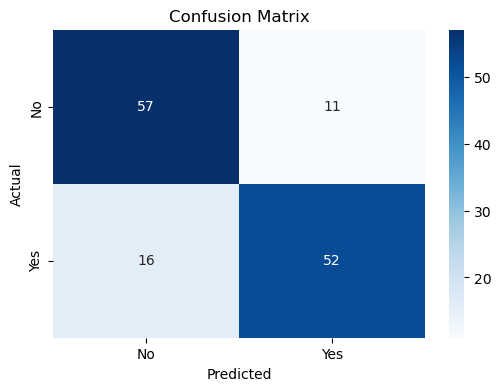

Accuracy: 80.15%
Recall: 76.47%
Precision: 82.54%
F1 Score: 79.39%


In [76]:
# K-Nearest Neighbors (KNN)
print("\n--- KNN Model ---")
knn = KNeighborsClassifier(n_neighbors=5)
knn_accuracy, knn_recall, knn_precision, knn_f1 = evaluate_model(knn, xtrain, xtest, ytrain, ytest)


--- SVM Model ---


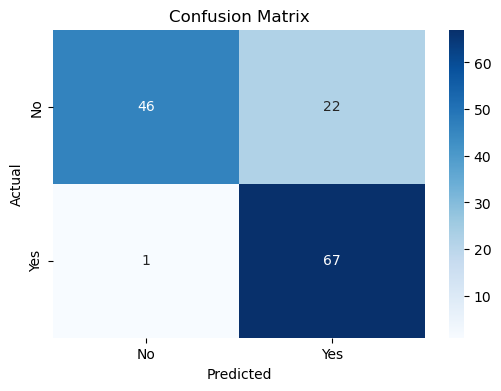

Accuracy: 83.09%
Recall: 98.53%
Precision: 75.28%
F1 Score: 85.35%

Explaining model: SVC


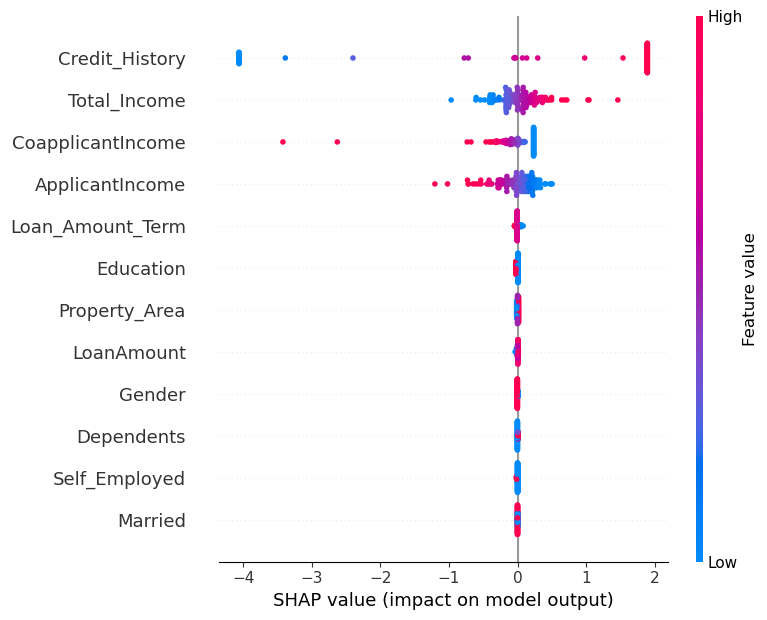

In [78]:
# Support Vector Machine (SVM)
print("\n--- SVM Model ---")
svm = SVC(kernel='linear', random_state=42, probability=True)
svm_accuracy, svm_recall, svm_precision, svm_f1 = evaluate_model(svm, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(svm, xtrain, xtest, X.columns)


--- Decision Tree Model ---


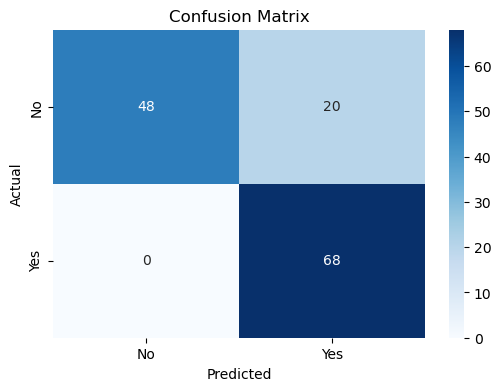

Accuracy: 85.29%
Recall: 100.00%
Precision: 77.27%
F1 Score: 87.18%

Explaining model: DecisionTreeClassifier


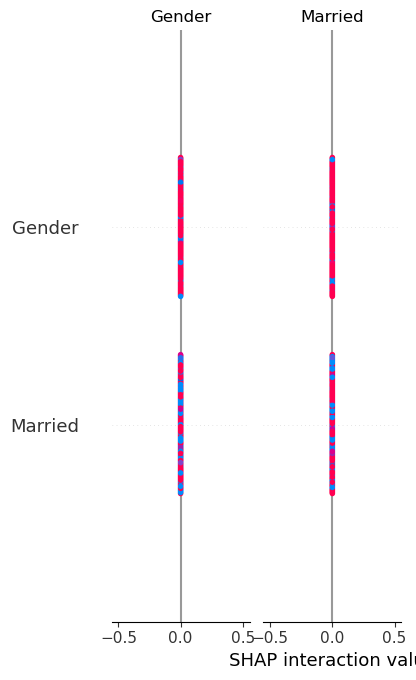

In [80]:
# Decision Tree
print("\n--- Decision Tree Model ---")
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
tree_accuracy, tree_recall, tree_precision, tree_f1 = evaluate_model(tree, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(tree, xtrain, xtest, X.columns)


--- XGBoost Model ---


C:\Users\eswar\anaconda3\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


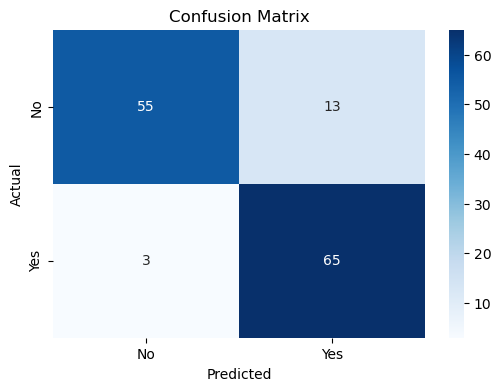

Accuracy: 88.24%
Recall: 95.59%
Precision: 83.33%
F1 Score: 89.04%

Explaining model: XGBClassifier


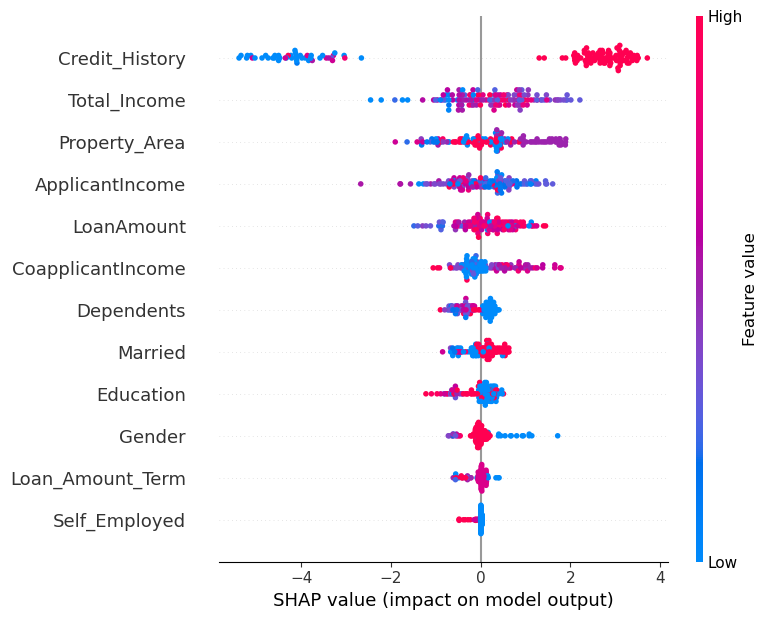

In [82]:
# XGBoost
print("\n--- XGBoost Model ---")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_accuracy, xgb_recall, xgb_precision, xgb_f1 = evaluate_model(xgb, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(xgb, xtrain, xtest, X.columns)


--- CatBoost Model ---


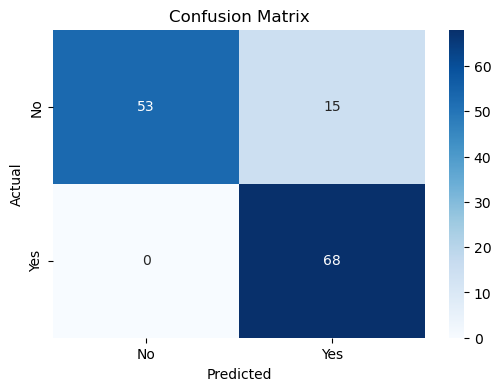

Accuracy: 88.97%
Recall: 100.00%
Precision: 81.93%
F1 Score: 90.07%

Explaining model: CatBoostClassifier


 92%|==================  | 125/136 [00:12<00:01]       

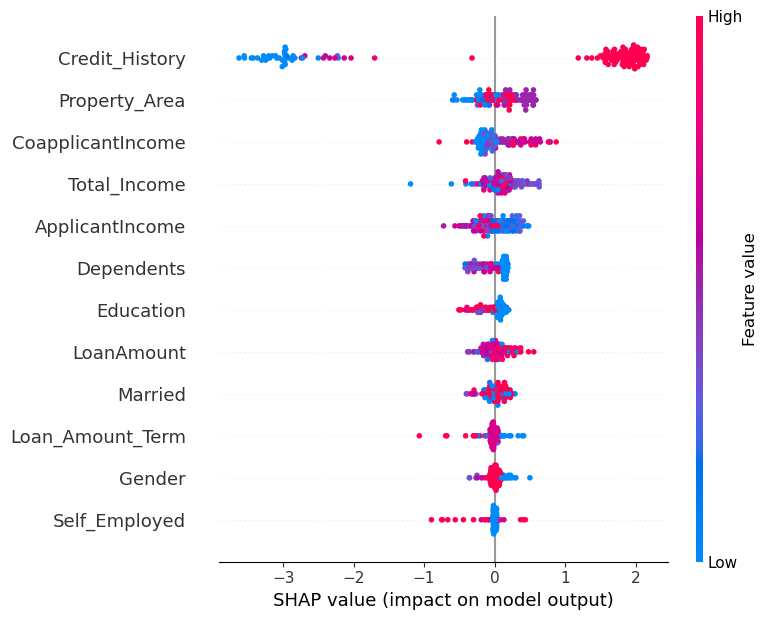

In [84]:
# CatBoost
print("\n--- CatBoost Model ---")
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost_accuracy, catboost_recall, catboost_precision, catboost_f1 = evaluate_model(catboost, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(catboost, xtrain, xtest, X.columns)


--- LightGBM Model ---
[LightGBM] [Info] Number of positive: 203, number of negative: 203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

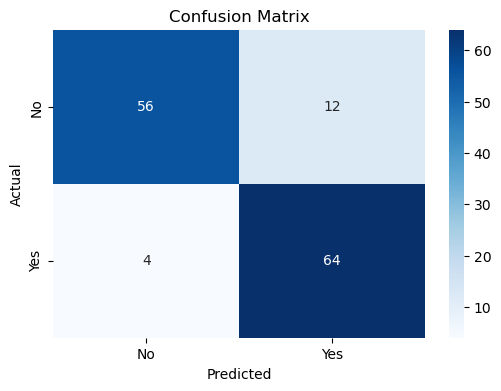

Accuracy: 88.24%
Recall: 94.12%
Precision: 84.21%
F1 Score: 88.89%

Explaining model: LGBMClassifier


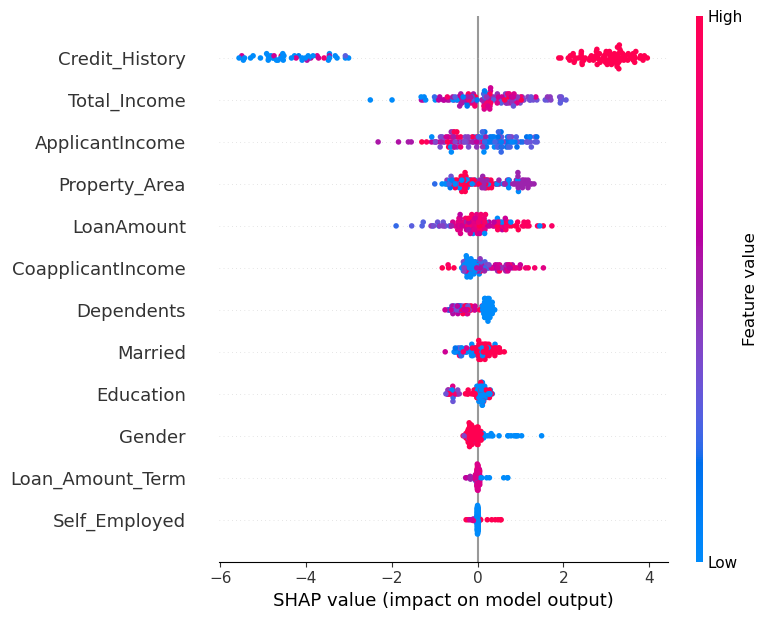

In [85]:
# LightGBM
print("\n--- LightGBM Model ---")
lightgbm = LGBMClassifier(random_state=42)
lightgbm_accuracy, lightgbm_recall, lightgbm_precision, lightgbm_f1 = evaluate_model(lightgbm, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(lightgbm, xtrain, xtest, X.columns)


--- Stacking Classifier ---


C:\Users\eswar\anaconda3\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:00:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 203, number of negative: 203
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\eswar\anaconda3\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 162, number of negative: 162
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 324, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

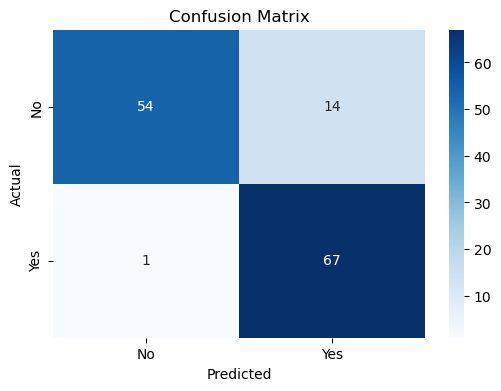

Accuracy: 88.97%
Recall: 98.53%
Precision: 82.72%
F1 Score: 89.93%

Explaining StackingClassifier...

Explaining base model: svm

Explaining model: SVC


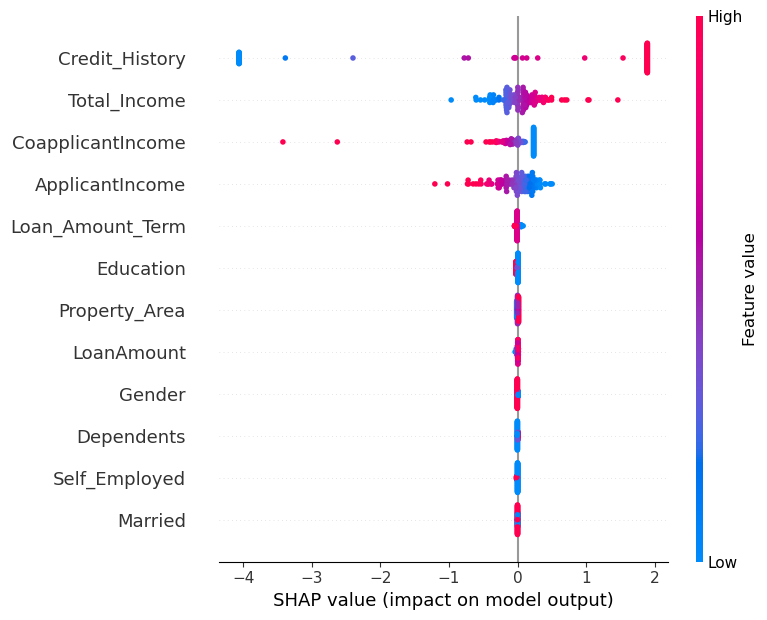


Explaining base model: tree

Explaining model: DecisionTreeClassifier


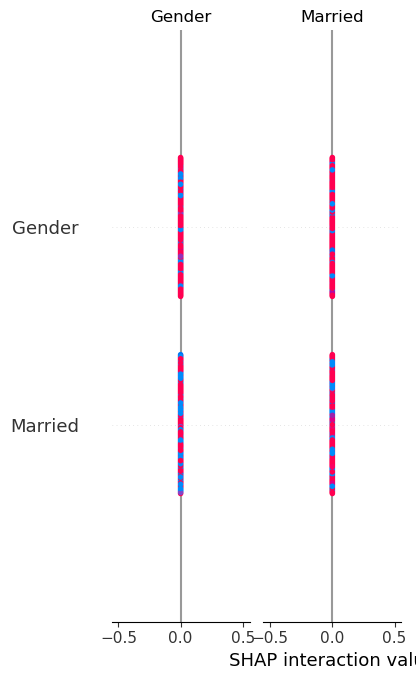


Explaining base model: xgb

Explaining model: XGBClassifier


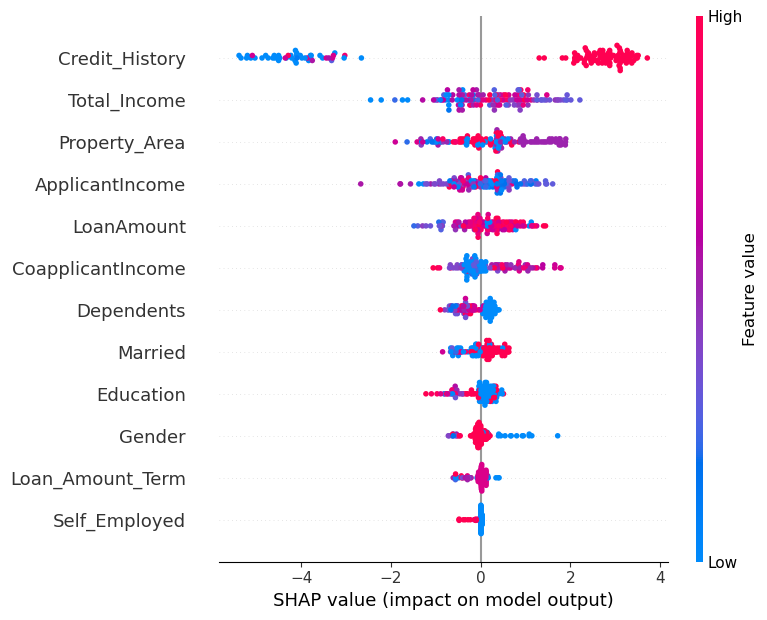


Explaining base model: catboost

Explaining model: CatBoostClassifier


 93%|=================== | 127/136 [00:12<00:00]       

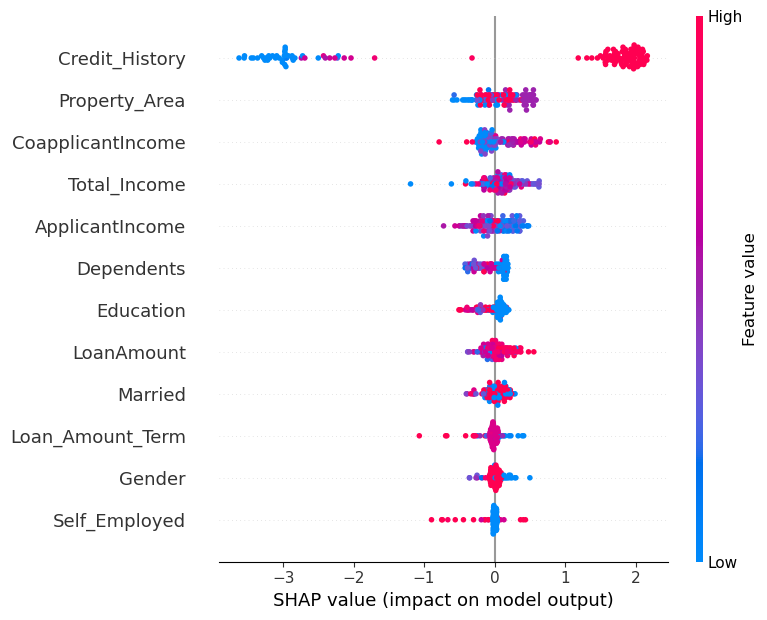


Explaining base model: lightgbm

Explaining model: LGBMClassifier


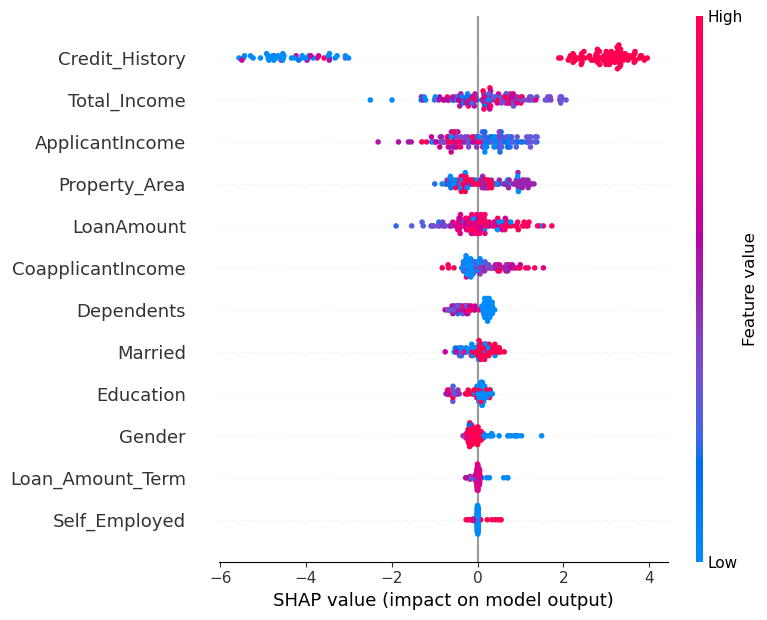


Explaining final estimator (meta-model)...


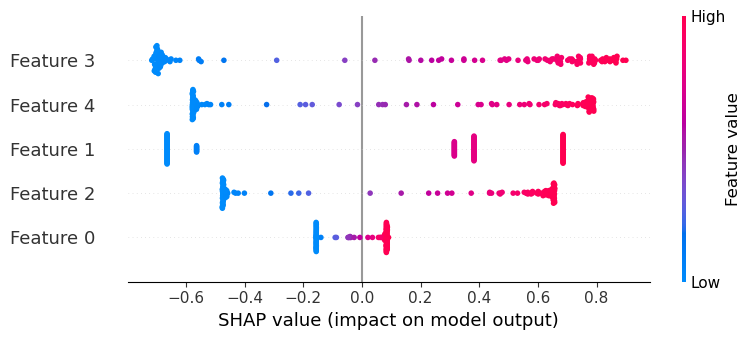

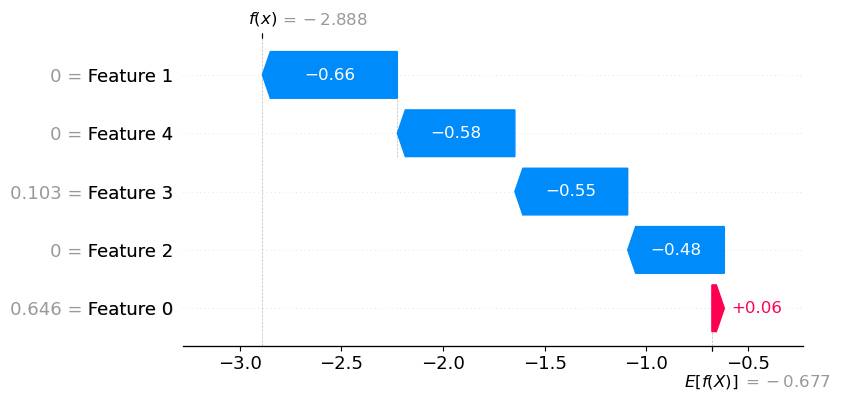

In [88]:
# Stacking Classifier
print("\n--- Stacking Classifier ---")
stacking_model = StackingClassifier(
    estimators=[('svm', svm), ('tree', tree),('xgb', xgb), ('catboost', catboost), ('lightgbm', lightgbm)],
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_accuracy, stacking_recall, stacking_precision, stacking_f1 = evaluate_model(stacking_model, xtrain, xtest, ytrain, ytest)
explain_model_with_shap(stacking_model, xtrain, xtest, X.columns)

In [90]:
# Metrics Summary
metrics = {
   "KNN": {"Accuracy": knn_accuracy, "Precision": knn_precision, "F1 Score": knn_f1, "Recall": knn_recall},
    "SVM": {"Accuracy": svm_accuracy, "Precision": svm_precision, "F1 Score": svm_f1, "Recall": svm_recall},
    "Decision Tree": {"Accuracy": tree_accuracy, "Precision": tree_precision, "F1 Score": tree_f1, "Recall": tree_recall},
    "XGBoost": {"Accuracy": xgb_accuracy, "Precision": xgb_precision, "F1 Score": xgb_f1, "Recall": xgb_recall},
    "CatBoost": {"Accuracy": catboost_accuracy, "Precision": catboost_precision, "F1 Score": catboost_f1, "Recall": catboost_recall},
    "LightGBM": {"Accuracy": lightgbm_accuracy, "Precision": lightgbm_precision, "F1 Score": lightgbm_f1, "Recall": lightgbm_recall},
    "Stacking": {"Accuracy": stacking_accuracy, "Precision": stacking_precision, "F1 Score": stacking_f1, "Recall": stacking_recall}
}

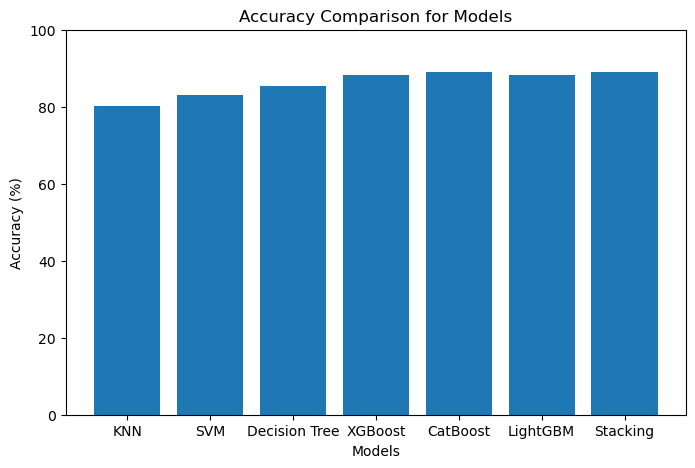

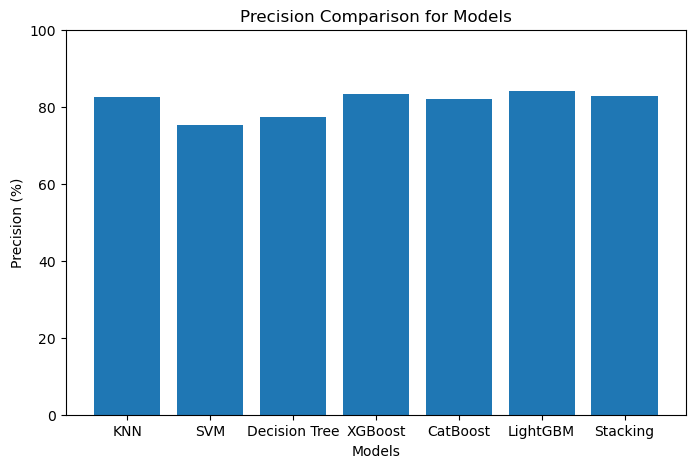

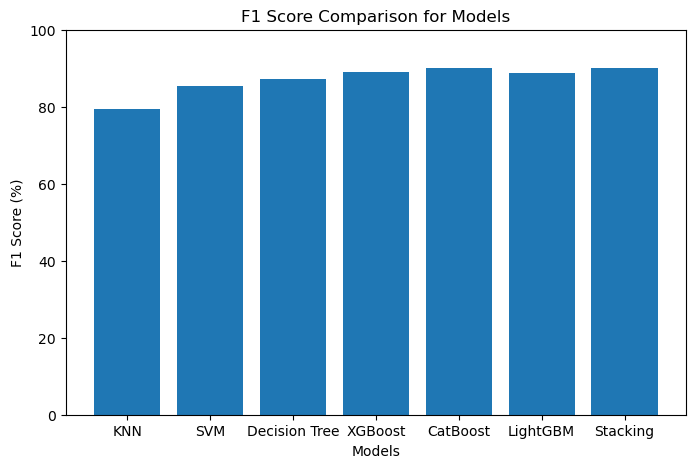

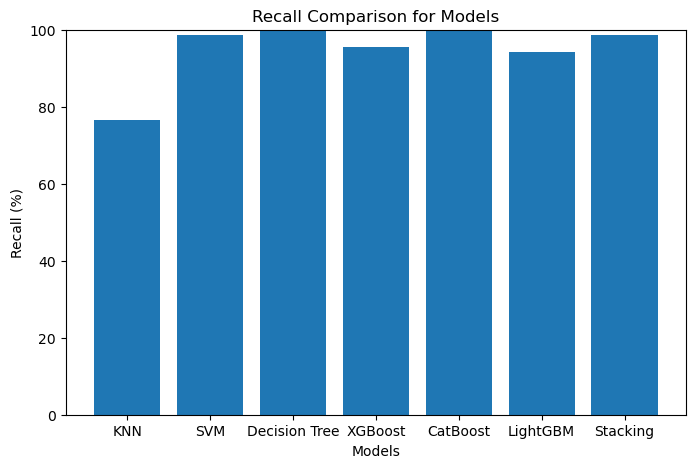

In [92]:
# Plot Metrics Comparison Separately
metrics_labels = ["Accuracy", "Precision", "F1 Score", "Recall"]
metrics_values = {
    "Accuracy": [knn_accuracy, svm_accuracy, tree_accuracy, xgb_accuracy, catboost_accuracy, lightgbm_accuracy, stacking_accuracy],
    "Precision": [knn_precision, svm_precision, tree_precision, xgb_precision, catboost_precision, lightgbm_precision, stacking_precision],
    "F1 Score": [knn_f1, svm_f1, tree_f1, xgb_f1, catboost_f1, lightgbm_f1, stacking_f1],
    "Recall": [knn_recall, svm_recall, tree_recall, xgb_recall, catboost_recall, lightgbm_recall, stacking_recall]
}

for metric_label in metrics_labels:
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics_values[metric_label])
    plt.title(f"{metric_label} Comparison for Models")
    plt.xlabel("Models")
    plt.ylabel(f"{metric_label} (%)")
    plt.ylim(0, 100)
    plt.show()

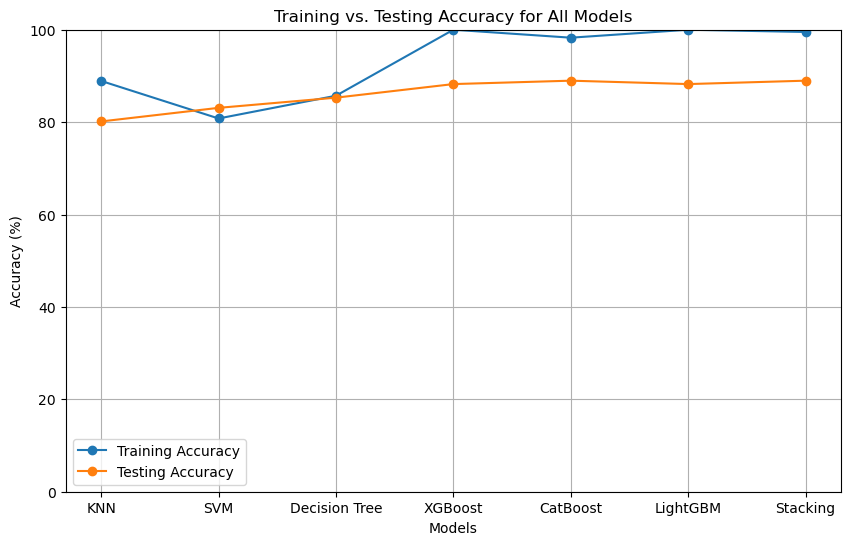

In [96]:
# Prepare data for training vs. testing accuracy plot
models = ["KNN", "SVM", "Decision Tree", "XGBoost", "CatBoost", "LightGBM", "Stacking"]
training_accuracies = []
testing_accuracies = []

# Calculate training accuracy for each model
for model_name, model_obj in zip(
    models,
    [knn, svm, tree, xgb, catboost, lightgbm, stacking_model]
):
    training_accuracies.append(accuracy_score(ytrain, model_obj.predict(xtrain)) * 100)
    testing_accuracies.append(accuracy_score(ytest, model_obj.predict(xtest)) * 100)

# Plot training vs. testing accuracies
plt.figure(figsize=(10, 6))
plt.plot(models, training_accuracies, marker='o', label='Training Accuracy')
plt.plot(models, testing_accuracies, marker='o', label='Testing Accuracy')
plt.title('Training vs. Testing Accuracy for All Models')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()



--- Best Model Summary ---
Model         CatBoost
Accuracy     88.970588
Recall           100.0
Precision    81.927711
F1 Score     90.066225
Name: 4, dtype: object


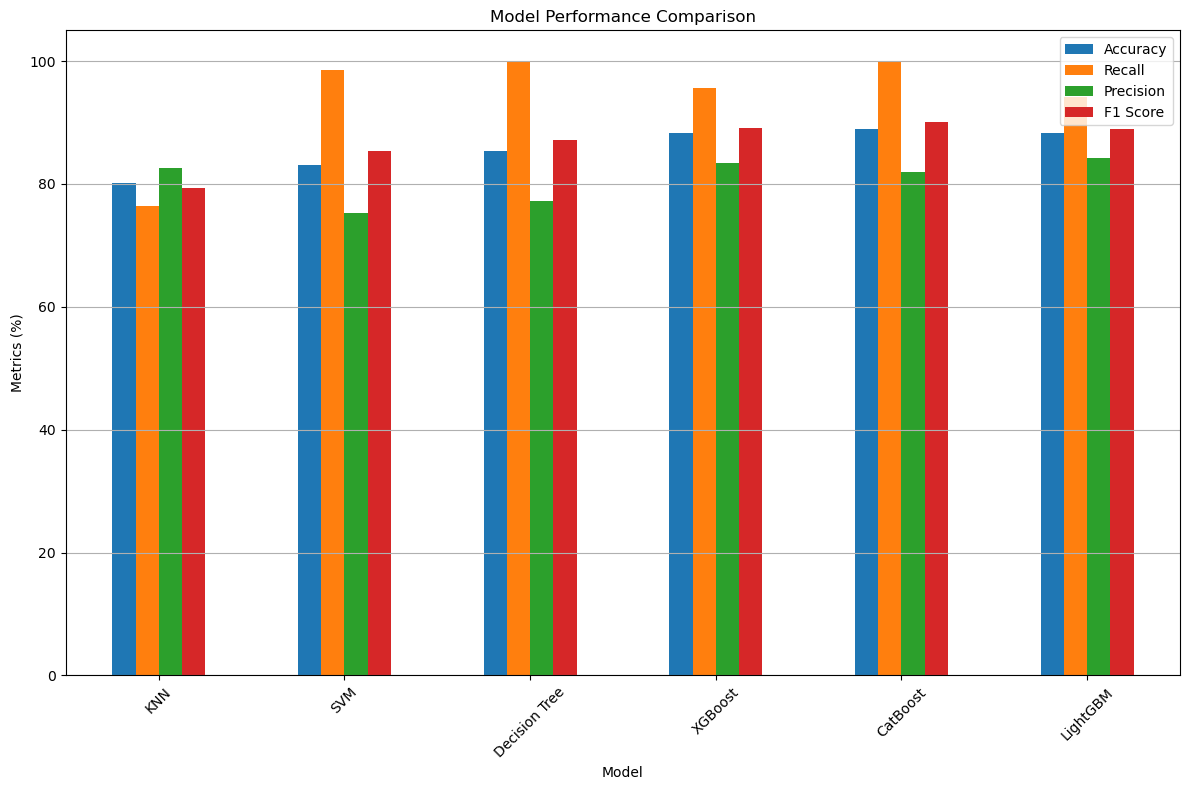

In [116]:
# Create a DataFrame to summarize all model metrics
metrics_summary = pd.DataFrame({
    "Model": ["KNN", "SVM", "Decision Tree", "XGBoost", "CatBoost", "LightGBM"],
    "Accuracy": [knn_accuracy, svm_accuracy, tree_accuracy, xgb_accuracy, catboost_accuracy, lightgbm_accuracy],
    "Recall": [knn_recall, svm_recall, tree_recall, xgb_recall, catboost_recall, lightgbm_recall],
    "Precision": [knn_precision, svm_precision, tree_precision, xgb_precision, catboost_precision, lightgbm_precision],
    "F1 Score": [knn_f1, svm_f1, tree_f1, xgb_f1, catboost_f1, lightgbm_f1]
})

# Find the best model based on F1 Score
best_model = metrics_summary.loc[metrics_summary["F1 Score"].idxmax()]
print("\n--- Best Model Summary ---")
print(best_model)

# Plot comparison of metrics for all models
metrics_summary.set_index("Model").plot(kind="bar", figsize=(12, 8))
plt.title("Model Performance Comparison")
plt.ylabel("Metrics (%)")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
